Import bibliotek

In [58]:
import numpy as np
import pandas as pd
from anytree import Node, RenderTree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import _tree
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from rich.tree import Tree as RichTree
from rich import print
from rich.console import Console
import json
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

Implementacja drzewa

In [59]:
class CustomDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, similarity_threshold=0.01, preference_list=None,
                 interactive=False, interactive_threshold=0.01, random_state=None, min_samples_split=2):
        self.max_depth = max_depth
        self.similarity_threshold = similarity_threshold
        self.preference_list = preference_list or []
        self.interactive = interactive
        self.interactive_threshold = interactive_threshold
        self.random_state = random_state
        self.min_samples_split = min_samples_split
        self.tree_ = None

    def _calculate_split_quality(self, X, y, feature_index):
        values = X[:, feature_index]
        unique_values = np.unique(values)
        splits = [y[values == val] for val in unique_values]
        weighted_gini = sum(len(s) / len(y) * (1 - sum((np.mean(s == c) ** 2 for c in np.unique(s)))) for s in splits)
        return -weighted_gini

    def _choose_split(self, qualities):
        best_quality = qualities[0][1]
        candidates = [q for q in qualities if abs(q[1] - best_quality) <= self.similarity_threshold]
        if self.interactive and abs(candidates[0][1] - candidates[-1][1]) <= self.interactive_threshold:
            print("Smiliar quality for features:")
            for idx, (f, q) in enumerate(candidates):
                print(f"{idx}: Feature {f} (Quality: {q:.4f})")
            choice = int(input("Choose feature (index): "))
            if choice < 0 or choice >= len(candidates):
                print("Invalid choice, using the first candidate.")
                choice = 0
            return candidates[choice][0]

        if self.preference_list:
            candidate_features = {f for f, _ in candidates}
            for preferred in self.preference_list:
                if preferred in candidate_features:
                    return preferred
        return candidates[0][0]

    def _build_tree(self, X, y, depth=0, used_features=None):
        if used_features is None:
            used_features = set()

        if (self.max_depth is not None and depth >= self.max_depth) or len(set(y)) == 1 or \
           len(y) < self.min_samples_split or (len(used_features) == X.shape[1]):
            return {
                'type': 'leaf',
                'class': np.bincount(y).argmax(),
                'label_counts': np.bincount(y, minlength=2)
            }

        qualities = [
            (i, q)
            for i in range(X.shape[1]) if i not in used_features
            for q in [self._calculate_split_quality(X, y, i)]
        ]
        if not qualities:
            return {
                'type': 'leaf',
                'class': np.bincount(y).argmax(),
                'label_counts': np.bincount(y, minlength=2)
            }

        qualities.sort(key=lambda x: -x[1])
        feature = self._choose_split(qualities)
        new_used_features = used_features.copy()
        new_used_features.add(feature)

        default_class = np.bincount(y).argmax()
        node = {'type': 'split', 'feature': feature, 'branches': {}, 'default_class': default_class}

        values = np.unique(X[:, feature])
        for val in values:
            idx = X[:, feature] == val
            if np.sum(idx) == 0:
                continue
            node['branches'][val] = self._build_tree(X[idx], y[idx], depth + 1, new_used_features)

        if not node['branches']:
            return {
                'type': 'leaf',
                'class': default_class,
                'label_counts': np.bincount(y, minlength=2)
            }

        return node

    def fit(self, X, y):
        self.tree_ = self._build_tree(np.array(X), np.array(y))
        return self

    def _predict_sample(self, x, node):
        if node['type'] == 'leaf':
            return node['class']
        val = x[node['feature']]
        branch = node['branches'].get(val)
        if branch is None:
            return node.get('default_class', 0)
        return self._predict_sample(x, branch)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree_) for x in X.to_numpy()])

    def predict_proba(self, X):
        def _predict_proba_sample(x, node):
            if node['type'] == 'leaf':
                counts = np.zeros(2)
                total = sum(node.get('label_counts', [0]))
                if total > 0:
                    counts[:len(node['label_counts'])] = node['label_counts']
                    return counts / total
                else:
                    return np.array([0.5, 0.5])
            val = x[node['feature']]
            branch = node['branches'].get(val)
            if branch is None:
                return np.array([0.5, 0.5])
            return _predict_proba_sample(x, branch)

        return np.array([_predict_proba_sample(x, self.tree_) for x in X.to_numpy()])

    def to_rich(self, node=None):
        if node is None:
            node = self.tree_

        def build_tree(node):
            if node['type'] == 'leaf':
                return RichTree(f"[green]Klasa: {node['class']}[/green]")

            tree = RichTree(f"[cyan]Cecha {node['feature']}[/cyan]")
            for val, child in node['branches'].items():
                branch = build_tree(child)
                subtree = tree.add(f"[yellow]Wartość = {val}[/yellow]")
                subtree.children.append(branch)
            return tree

        return build_tree(node)


Evaluate model

In [60]:
def train_and_evaluate(model, X, y, target_names=None, test_size=0.2, random_state=42):
    # Data split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_micro = f1_score(y_val, y_pred, average='micro')
    cm = confusion_matrix(y_val, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"F1 Score (micro): {f1_micro:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # ROC + AUC only for binary classification
    if len(np.unique(y_val)) == 2:
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_val)[:, 1]
        else:
            try:
                y_scores = model.decision_function(X_val)
            except:
                print("Model does not support decision function or predict_proba.")
                return

        fpr, tpr, _ = roc_curve(y_val, y_scores)
        roc_auc = auc(fpr, tpr)
        
        print(f"AUC: {roc_auc:.4f}")
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
        plt.title("ROC Curve")
        plt.show()
    else:
        print("ROC + AUC only for binary classification.")
    
    return model

def evaluate_model(model, X, y, target_names=None):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_micro = f1_score(y, y_pred, average='micro')
    cm = confusion_matrix(y, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"F1 Score (micro): {f1_micro:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

Przykład wywołania (preferencje)

Accuracy: 0.9618

F1 Score (macro): 0.9618

F1 Score (micro): 0.9618

Confusion Matrix:
[[816  26]
 [ 36 747]]

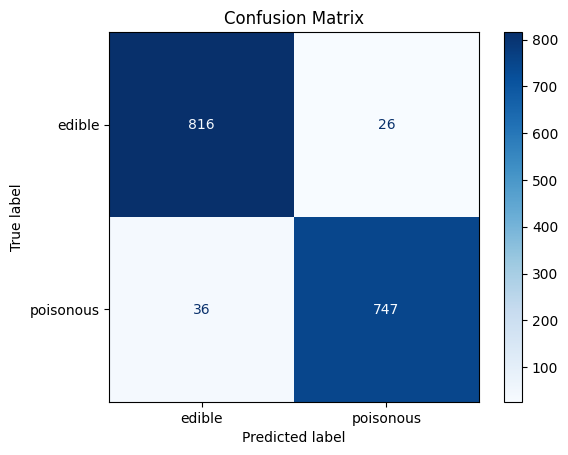

AUC: 0.9933

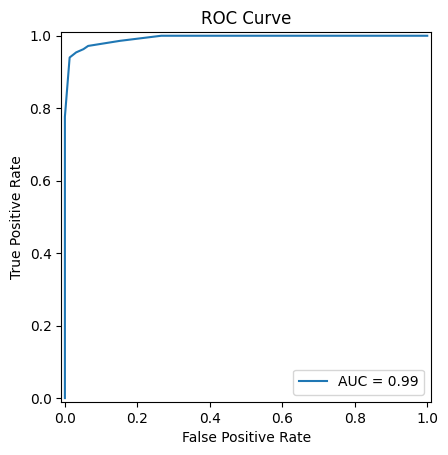

Cecha 21
├── Wartość = 0
│   └── Cecha 20
│       ├── Wartość = 1
│       │   └── Klasa: 1
│       ├── Wartość = 3
│       │   └── Klasa: 1
│       ├── Wartość = 4
│       │   └── Cecha 19
│       │       ├── Wartość = 1
│       │       │   └── Cecha 18
│       │       │       ├── Wartość = 1
│       │       │       │   └── Klasa: 0
│       │       │       └── Wartość = 2
│       │       │           └── Klasa: 1
│       │       ├── Wartość = 2
│       │       │   └── Cecha 18
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 3
│       │       │   └── Cecha 18
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 6
│       │       │   └── Klasa: 0
│       │       └── Wartość = 7
│       │           └── Klasa: 1
│       └── Wartość = 5
│           └── Cecha 19
│               ├── Wartość = 1
│               │   └── Cecha 18
│               │       ├── Wartość = 1
│               │       │   └── Klasa: 0
│               │       └── Wartość = 2
│               │           └── Klasa: 1
│               ├── Wartość = 2
│               │   └── Klasa: 0
│               ├── Wartość = 3
│               │   └── Klasa: 0
│               └── Wartość = 7
│                   └── Klasa: 0
├── Wartość = 1
│   └── Cecha 20
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 2
│       │   └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Cecha 19
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 1
│       │       ├── Wartość = 2
│       │       │   └── Cecha 18
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 0
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 3
│       │       │   └── Cecha 18
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 0
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       └── Wartość = 7
│       │           └── Klasa: 0
│       ├── Wartość = 4
│       │   └── Klasa: 1
│       └── Wartość = 5
│           └── Cecha 19
│               ├── Wartość = 1
│               │   └── Klasa: 1
│               ├── Wartość = 2
│               │   └── Klasa: 0
│               └── Wartość = 3
│                   └── Klasa: 0
├── Wartość = 2
│   └── Cecha 20
│       ├── Wartość = 1
│       │   └── Cecha 19
│       │       ├── Wartość = 0
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 3
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 4
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 7
│       │       │   └── Klasa: 1
│       │       └── Wartość = 8
│       │           └── Klasa: 0
│       └── Wartość = 4
│           └── Cecha 19
│               ├── Wartość = 0
│               │   └── Klasa: 0
│               ├── Wartość = 3
│               │   └── Klasa: 0
│               ├── Wartość = 4
│               │   └── Klasa: 0
│               ├── Wartość = 7
│               │   └── Cecha 18
│               │       └── Wartość = 0
│               │           └── Klasa: 1
│               └── Wartość = 8
│                   └── Klasa: 0
├── Wartość = 3
│   └── Cecha 20
│       ├── Wartość = 2
│       │   └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       └── Wartość = 4
│           └── Klasa: 1
├── Wartość = 4
│   └── Cecha 20
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       ├── Wartość = 4
│       │   └── Cecha 19
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 1
│       │       └── Wartość = 7
│       │           └── Cecha 18
│       │               ├── Wartość = 0
│       │               │   └── Klasa: 1
│       │               └── Wartość = 4
│       │                   └── Klasa: 0
│       └── Wartość = 5
│           └── Cecha 19
│               ├── Wartość = 1
│               │   └── Klasa: 1
│               ├── Wartość = 2
│               │   └──

In [61]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

feature_order = list(range(X.shape[1]))
clf = CustomDecisionTreeClassifier(preference_list=feature_order[::-1],
                                   similarity_threshold=0.5,
                                   max_depth=4,
                                   min_samples_split=5)
                                   
clf_trained = train_and_evaluate(clf, X, y, test_size=0.2, random_state=3928, target_names=["edible", "poisonous"])
console = Console()
console.print(clf_trained.to_rich())


Przykład wywołania (interaktywny)

Smiliar quality for features:

0: Feature 4 (Quality: -0.0285)

1: Feature 19 (Quality: -0.2165)

2: Feature 8 (Quality: -0.2679)

3: Feature 18 (Quality: -0.3176)

4: Feature 11 (Quality: -0.3267)

5: Feature 12 (Quality: -0.3343)

6: Feature 7 (Quality: -0.3537)

7: Feature 13 (Quality: -0.3618)

8: Feature 14 (Quality: -0.3671)

9: Feature 3 (Quality: -0.3738)

10: Feature 20 (Quality: -0.3807)

11: Feature 21 (Quality: -0.4026)

12: Feature 10 (Quality: -0.4167)

13: Feature 6 (Quality: -0.4387)

14: Feature 0 (Quality: -0.4692)

15: Feature 2 (Quality: -0.4755)

16: Feature 17 (Quality: -0.4763)

17: Feature 1 (Quality: -0.4800)

18: Feature 16 (Quality: -0.4876)

19: Feature 5 (Quality: -0.4910)

20: Feature 9 (Quality: -0.4942)

21: Feature 15 (Quality: -0.4994)

Smiliar quality for features:

0: Feature 4 (Quality: -0.0406)

1: Feature 19 (Quality: -0.0957)

2: Feature 9 (Quality: -0.1797)

3: Feature 11 (Quality: -0.1913)

4: Feature 12 (Quality: -0.1913)

5: Feature 3 (Quality: -0.1952)

6: Feature 2 (Quality: -0.2274)

7: Feature 18 (Quality: -0.2283)

8: Feature 8 (Quality: -0.2372)

9: Feature 21 (Quality: -0.2696)

10: Feature 13 (Quality: -0.3089)

11: Feature 14 (Quality: -0.3255)

12: Feature 1 (Quality: -0.4598)

13: Feature 20 (Quality: -0.4616)

14: Feature 0 (Quality: -0.4930)

15: Feature 7 (Quality: -0.4982)

16: Feature 17 (Quality: -0.4991)

17: Feature 6 (Quality: -0.4991)

18: Feature 5 (Quality: -0.4999)

19: Feature 15 (Quality: -0.4999)

20: Feature 16 (Quality: -0.4999)

Smiliar quality for features:

0: Feature 3 (Quality: -0.0000)

1: Feature 4 (Quality: -0.0000)

2: Feature 7 (Quality: -0.0000)

3: Feature 9 (Quality: -0.0000)

4: Feature 2 (Quality: -0.0600)

5: Feature 1 (Quality: -0.0900)

6: Feature 20 (Quality: -0.0900)

7: Feature 6 (Quality: -0.0947)

8: Feature 8 (Quality: -0.1350)

9: Feature 13 (Quality: -0.1500)

10: Feature 14 (Quality: -0.1500)

11: Feature 0 (Quality: -0.1636)

12: Feature 5 (Quality: -0.1800)

13: Feature 11 (Quality: -0.1800)

14: Feature 12 (Quality: -0.1800)

15: Feature 15 (Quality: -0.1800)

16: Feature 16 (Quality: -0.1800)

17: Feature 17 (Quality: -0.1800)

18: Feature 18 (Quality: -0.1800)

19: Feature 21 (Quality: -0.1800)

Smiliar quality for features:

0: Feature 3 (Quality: -0.0000)

1: Feature 4 (Quality: -0.0000)

2: Feature 9 (Quality: -0.0000)

3: Feature 7 (Quality: -0.0635)

4: Feature 2 (Quality: -0.0844)

5: Feature 20 (Quality: -0.0866)

6: Feature 1 (Quality: -0.1179)

7: Feature 8 (Quality: -0.1292)

8: Feature 6 (Quality: -0.1378)

9: Feature 13 (Quality: -0.1481)

10: Feature 14 (Quality: -0.1481)

11: Feature 0 (Quality: -0.1573)

12: Feature 5 (Quality: -0.1723)

13: Feature 11 (Quality: -0.1723)

14: Feature 12 (Quality: -0.1723)

15: Feature 15 (Quality: -0.1723)

16: Feature 16 (Quality: -0.1723)

17: Feature 17 (Quality: -0.1723)

18: Feature 18 (Quality: -0.1723)

19: Feature 21 (Quality: -0.1723)

Smiliar quality for features:

0: Feature 2 (Quality: -0.0000)

1: Feature 20 (Quality: -0.0000)

2: Feature 1 (Quality: -0.0710)

3: Feature 0 (Quality: -0.0970)

4: Feature 3 (Quality: -0.1231)

5: Feature 14 (Quality: -0.1231)

6: Feature 6 (Quality: -0.1319)

7: Feature 7 (Quality: -0.1319)

8: Feature 17 (Quality: -0.1319)

9: Feature 18 (Quality: -0.1319)

10: Feature 21 (Quality: -0.1319)

11: Feature 11 (Quality: -0.1346)

12: Feature 12 (Quality: -0.1346)

13: Feature 13 (Quality: -0.1399)

14: Feature 4 (Quality: -0.1420)

15: Feature 5 (Quality: -0.1420)

16: Feature 8 (Quality: -0.1420)

17: Feature 9 (Quality: -0.1420)

18: Feature 15 (Quality: -0.1420)

19: Feature 16 (Quality: -0.1420)

Smiliar quality for features:

0: Feature 3 (Quality: -0.0000)

1: Feature 4 (Quality: -0.0000)

2: Feature 11 (Quality: -0.0000)

3: Feature 12 (Quality: -0.0000)

4: Feature 13 (Quality: -0.0000)

5: Feature 14 (Quality: -0.0000)

6: Feature 18 (Quality: -0.0000)

7: Feature 19 (Quality: -0.0000)

8: Feature 20 (Quality: -0.0000)

9: Feature 21 (Quality: -0.0000)

10: Feature 2 (Quality: -0.0279)

11: Feature 17 (Quality: -0.0283)

12: Feature 0 (Quality: -0.0484)

13: Feature 8 (Quality: -0.0675)

14: Feature 5 (Quality: -0.0890)

15: Feature 6 (Quality: -0.1210)

16: Feature 7 (Quality: -0.1210)

17: Feature 16 (Quality: -0.1210)

18: Feature 1 (Quality: -0.1351)

19: Feature 9 (Quality: -0.1457)

20: Feature 15 (Quality: -0.1457)

Smiliar quality for features:

0: Feature 3 (Quality: -0.0000)

1: Feature 4 (Quality: -0.0000)

2: Feature 6 (Quality: -0.1247)

3: Feature 7 (Quality: -0.1247)

4: Feature 9 (Quality: -0.1247)

5: Feature 18 (Quality: -0.1247)

6: Feature 1 (Quality: -0.1714)

7: Feature 20 (Quality: -0.2338)

8: Feature 8 (Quality: -0.2645)

9: Feature 21 (Quality: -0.2939)

10: Feature 11 (Quality: -0.2981)

11: Feature 12 (Quality: -0.2981)

12: Feature 2 (Quality: -0.3132)

13: Feature 0 (Quality: -0.3496)

14: Feature 5 (Quality: -0.3527)

15: Feature 13 (Quality: -0.3527)

16: Feature 14 (Quality: -0.3527)

17: Feature 15 (Quality: -0.3527)

18: Feature 16 (Quality: -0.3527)

19: Feature 17 (Quality: -0.3527)

20: Feature 19 (Quality: -0.3527)

Smiliar quality for features:

0: Feature 8 (Quality: -0.0223)

1: Feature 4 (Quality: -0.0247)

2: Feature 9 (Quality: -0.0247)

3: Feature 7 (Quality: -0.0377)

4: Feature 20 (Quality: -0.0906)

5: Feature 18 (Quality: -0.1396)

6: Feature 21 (Quality: -0.1520)

7: Feature 17 (Quality: -0.1703)

8: Feature 2 (Quality: -0.1887)

9: Feature 14 (Quality: -0.2323)

10: Feature 13 (Quality: -0.2351)

11: Feature 6 (Quality: -0.2797)

12: Feature 19 (Quality: -0.3041)

13: Feature 3 (Quality: -0.3275)

14: Feature 5 (Quality: -0.3275)

15: Feature 16 (Quality: -0.3275)

16: Feature 1 (Quality: -0.3437)

17: Feature 0 (Quality: -0.3527)

18: Feature 12 (Quality: -0.3638)

19: Feature 11 (Quality: -0.3788)

20: Feature 15 (Quality: -0.4121)

Smiliar quality for features:

0: Feature 12 (Quality: -0.0000)

1: Feature 14 (Quality: -0.0000)

2: Feature 2 (Quality: -0.0399)

3: Feature 7 (Quality: -0.0511)

4: Feature 21 (Quality: -0.0511)

5: Feature 20 (Quality: -0.0672)

6: Feature 11 (Quality: -0.0696)

7: Feature 18 (Quality: -0.0729)

8: Feature 8 (Quality: -0.0736)

9: Feature 17 (Quality: -0.0751)

10: Feature 1 (Quality: -0.0766)

11: Feature 6 (Quality: -0.0792)

12: Feature 13 (Quality: -0.0792)

13: Feature 19 (Quality: -0.0798)

14: Feature 3 (Quality: -0.0802)

15: Feature 5 (Quality: -0.0802)

16: Feature 16 (Quality: -0.0802)

17: Feature 0 (Quality: -0.0813)

18: Feature 9 (Quality: -0.0815)

19: Feature 15 (Quality: -0.0815)

Accuracy: 1.0000

F1 Score (macro): 1.0000

F1 Score (micro): 1.0000

Confusion Matrix:
[[4208    0]
 [   0 3916]]

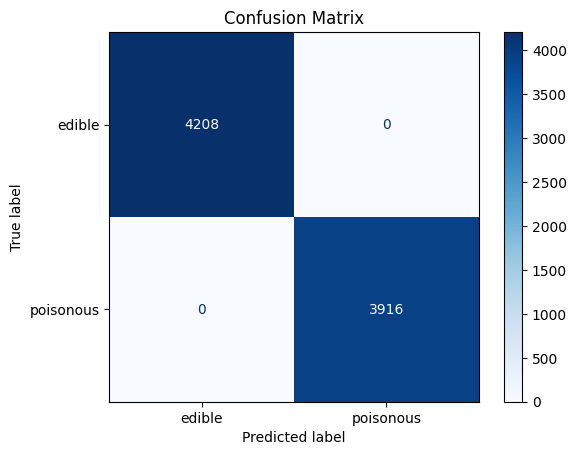

Cecha 10
├── Wartość = 0
│   └── Cecha 19
│       ├── Wartość = 1
│       │   └── Klasa: 1
│       ├── Wartość = 2
│       │   └── Cecha 4
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 1
│       │       └── Wartość = 5
│       │           └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Cecha 4
│       │       ├── Wartość = 0
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 1
│       │       ├── Wartość = 3
│       │       │   └── Klasa: 0
│       │       └── Wartość = 5
│       │           └── Klasa: 0
│       ├── Wartość = 5
│       │   └── Klasa: 1
│       ├── Wartość = 6
│       │   └── Klasa: 0
│       └── Wartość = 7
│           └── Cecha 20
│               ├── Wartość = 1
│               │   └── Klasa: 1
│               ├── Wartość = 4
│               │   └── Klasa: 0
│               └── Wartość = 5
│                   └── Klasa: 0
├── Wartość = 1
│   └── Cecha 4
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       ├── Wartość = 4
│       │   └── Klasa: 1
│       └── Wartość = 5
│           └── Klasa: 1
├── Wartość = 2
│   └── Cecha 4
│       ├── Wartość = 5
│       │   └── Klasa: 0
│       └── Wartość = 6
│           └── Klasa: 1
├── Wartość = 3
│   └── Klasa: 0
└── Wartość = 4
    └── Cecha 4
        ├── Wartość = 2
        │   └── Klasa: 1
        ├── Wartość = 5
        │   └── Cecha 14
        │       ├── Wartość = 2
        │       │   └── Klasa: 0
        │       ├── Wartość = 4
        │       │   └── Klasa: 1
        │       ├── Wartość = 5
        │       │   └── Klasa: 0
        │       ├── Wartość = 7
        │       │   └── Klasa: 0
        │       └── Wartość = 8
        │           └── Klasa: 1
        ├── Wartość = 7
        │   └── Klasa: 1
        └── Wartość = 8
            └── Klasa: 1

In [ ]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=3131, stratify=y
)
feature_order = list(range(X.shape[1]))
clf = CustomDecisionTreeClassifier(preference_list=feature_order[::-1],
                                   similarity_threshold=0.5,
                                   max_depth=4,
                                   min_samples_split=5,
                                   interactive=True,
                                   interactive_threshold=0.5)
clf.fit(X_train, y_train)
evaluate_model(clf, X_val, y_val, target_names=["edible", "poisonous"])
console = Console()
console.print(clf.to_rich())